# Homework 10

### Principles of Urban Informatics

#### Completed by #JKtours

# TIME SERIES ANALYSIS



# Goal: Find outliers, trends and periodicity in the MTA turnstile data
    

## DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.


The data was organized  by Dr. Sina Kashuk at CUSP.
You can get it from the github repo (use the download link to download it live in your notebook). 
It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


In [1]:
__author__ = 'JKtours'
import pylab as pl
import pandas as pd
import os
import json
import statsmodels.api as sm
import collections 

%pylab inline


Populating the interactive namespace from numpy and matplotlib


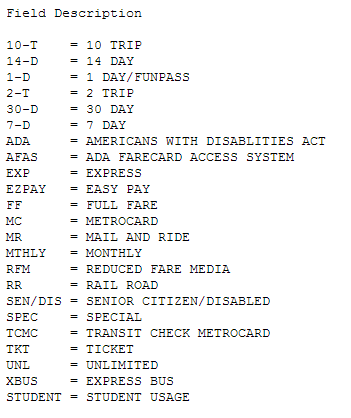

In [2]:
from IPython.display import Image
Image(filename = "Ridetypes.png")

## Each time series (per station, per ticket type) contains the number of swipes per week for 194 weeks from 05/21/2010 to 02/21/2014. 


In [3]:
 #get file from website, and puts into active directory

!curl -O https://raw.githubusercontent.com/fedhere/PUI2017_fb55/master/HW10_fb55/MTA_Fare.npy  

os.system("mv MTA_Fare.npy " + os.getenv("PUIDATA"))

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10.2M  100 10.2M    0     0  10.2M      0  0:00:01 --:--:--  0:00:01 59.0M


0

In [4]:
theData = np.load(os.getenv("PUIDATA") + '/' + 'MTA_Fare.npy')

In [5]:
theData.shape

(600, 23, 194)

## The data provides number of swipes for 600 stations by ticket type (with a total of 23 ticket types) across 194 weeks.


In [6]:
theData[0][0][0]     
# theData[0 -> first station][0 -> first ticket type: 10 TRIP][0 -> first week: 05/21/2010], 
# there were 56961 swipes

56961

Remove missing values (which were input as -1)

In [7]:
theDataClean = theData.astype(np.float)

In [8]:
np.place(theDataClean, theDataClean == -1, np.nan)

## Task 1: 
### Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
### Identify it, figure out the date (you know when the data starts and what the cadence is) and figure out what it is due to.

We want to sum all ticket types across all stations by week. i.e. sum the first two dimensions for each week.

In [9]:
len(np.nansum(theDataClean,axis=1))

600

In [10]:
dates = pd.date_range(start="05/21/2010", freq='W',periods=194)
dates

DatetimeIndex(['2010-05-23', '2010-05-30', '2010-06-06', '2010-06-13',
               '2010-06-20', '2010-06-27', '2010-07-04', '2010-07-11',
               '2010-07-18', '2010-07-25',
               ...
               '2013-12-01', '2013-12-08', '2013-12-15', '2013-12-22',
               '2013-12-29', '2014-01-05', '2014-01-12', '2014-01-19',
               '2014-01-26', '2014-02-02'],
              dtype='datetime64[ns]', length=194, freq='W-SUN')

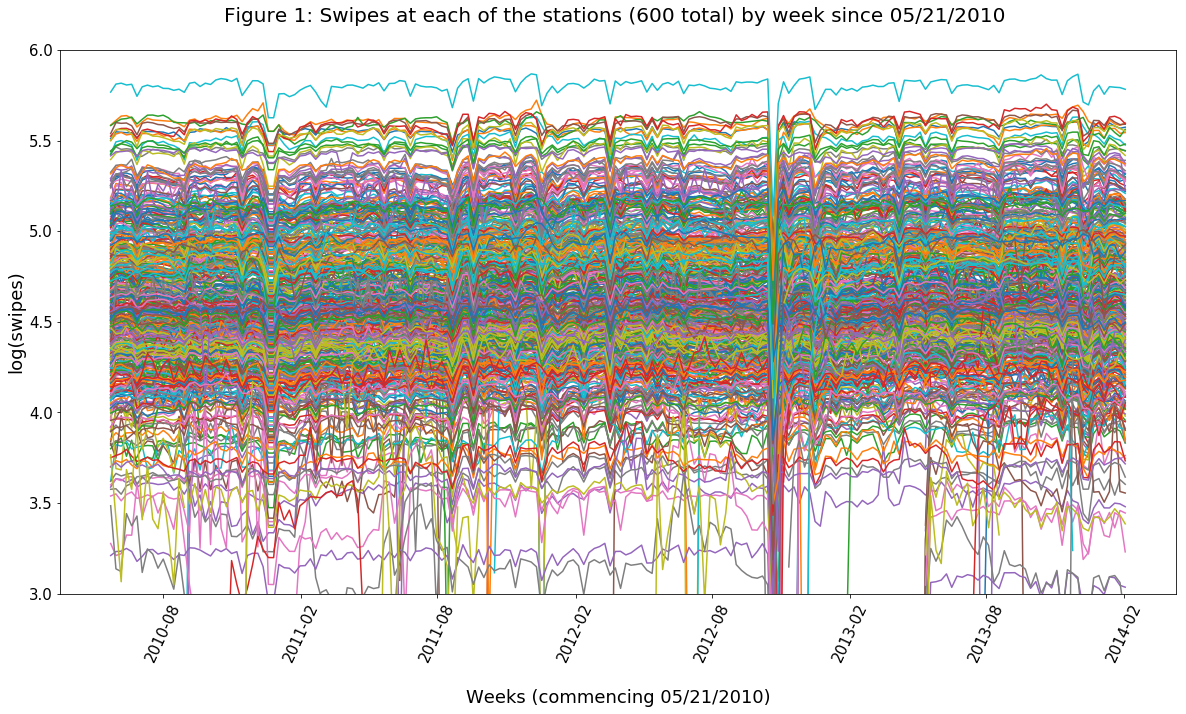

In [11]:
#after that I create a date range (for example with pd.date_range())
#in a log plot to enhance the visibility along the y axis (np.log10(weightedrides[i]))
#all time series, each station each ride type, look like this (pretty ugly)


fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)

for i in range(len(np.nansum(theDataClean,axis=1))):
    ax.plot(dates, np.log10(np.nansum(theDataClean,axis=1)[i]))
    #ax.set_yscale('log')
ax.tick_params(axis='both',labelsize=16)
pl.title("Figure 1: Swipes at each of the stations (600 total) by week since 05/21/2010 \n", fontsize=20)
pl.xticks(rotation='65', fontsize = 15)
pl.yticks(fontsize = 15)
#ax.xaxis.set_major_formatter(FuncFormatter(format_fn))
#ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_ylabel("log(swipes)", fontsize=18)
ax.set_xlabel("\nWeeks (commencing 05/21/2010)", fontsize=18)
ax.set_ylim(3,6)#0,100)1e4,1e6);
ax.set_xlim();

**Figure 1:** Plot of all station swipes by week from May 2010 to Feb 2014.

There appears to be a significant event around October 2012. Let's inspect the series with the highest volume.

In [12]:
highestVolID = np.argmax(np.nansum(np.nansum(theDataClean,axis=1),axis=1))

In [13]:
highestVolTix = np.nansum(theDataClean,axis=1)[highestVolID]

In [14]:
thresholds = [highestVolTix.mean() + 3 * highestVolTix.std(), 
              highestVolTix.mean() - 3 * highestVolTix.std()]
thresh = np.log10(highestVolTix * 0 + thresholds[1])

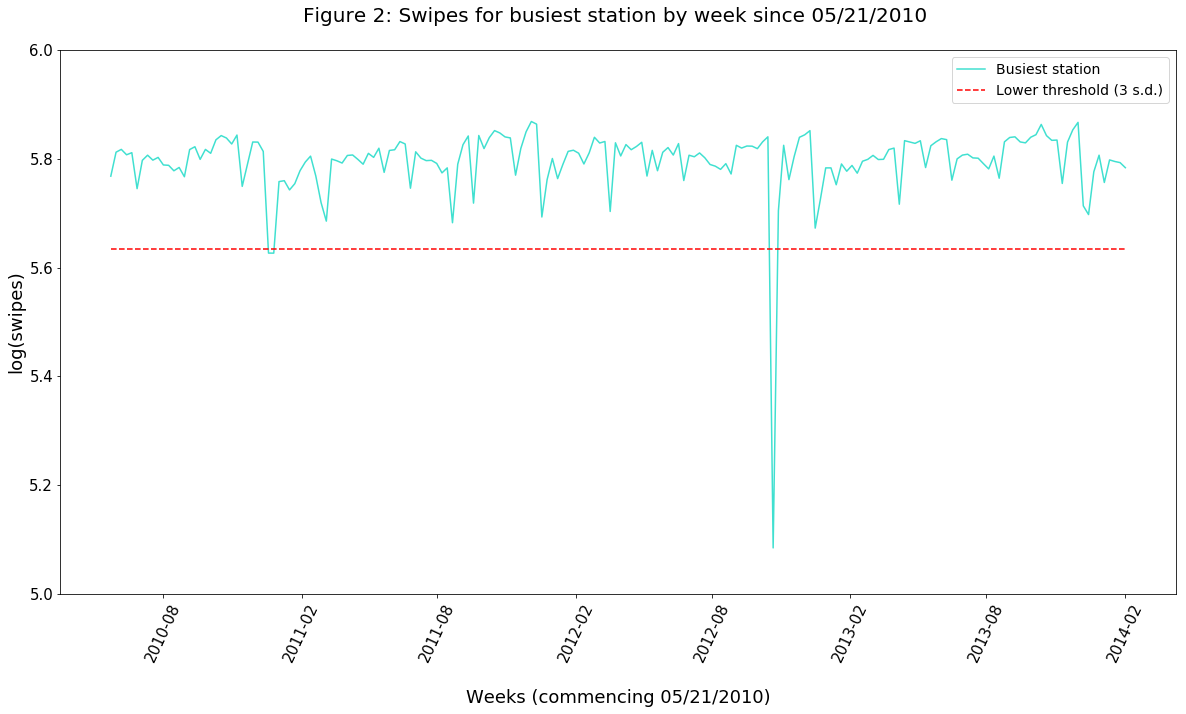

In [15]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)


ax.plot(dates, np.log10(np.nansum(theDataClean,axis=1)[highestVolID]), color='turquoise'
        , label = "Busiest station")
ax.plot(dates, thresh, 'r--', label = "Lower threshold (3 s.d.)")
    #ax.set_yscale('log')
ax.tick_params(axis='both',labelsize=16)
pl.title("Figure 2: Swipes for busiest station by week since 05/21/2010 \n", fontsize=20)
pl.xticks(rotation='65', fontsize = 15)
pl.yticks(fontsize = 15)
#ax.xaxis.set_major_formatter(FuncFormatter(format_fn))
#ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_ylabel("log(swipes)", fontsize=18)
ax.set_xlabel("\nWeeks (commencing 05/21/2010)", fontsize=18)
ax.set_ylim(5,6)#0,100)1e4,1e6);
ax.set_xlim()
plt.legend(fontsize=14);

**Figure 2:** Plot of all swipes by week for busiest station over time.

Plotting the busiest station confirms our suspicions there was a significant drop in swipes around October 2012. This appears to be a significant event. Let's identify which week it is.

In [16]:
WeekID = np.argmin(highestVolTix)
print("The week number of the specific event is {}".format(WeekID) + 
      " which corresponds to the week {}".format(dates[WeekID]))

The week number of the specific event is 126 which corresponds to the week 2012-10-21 00:00:00


The week identified has start date 21 October 2012. Keep in mind, it may not be exactly this date, but potentially a week or two either side of this date. We tested the busiest station. Let's assess if this is consistent with the average of all stations also.

In [17]:
avgStationSwipesCount = np.nanmean(np.nansum(theDataClean,axis=1), axis = 0)

thresholds = [avgStationSwipesCount.mean() + 3 * avgStationSwipesCount.std(), 
              avgStationSwipesCount.mean() - 3 * avgStationSwipesCount.std()]
thresh = np.log10(avgStationSwipesCount * 0 + thresholds[1])


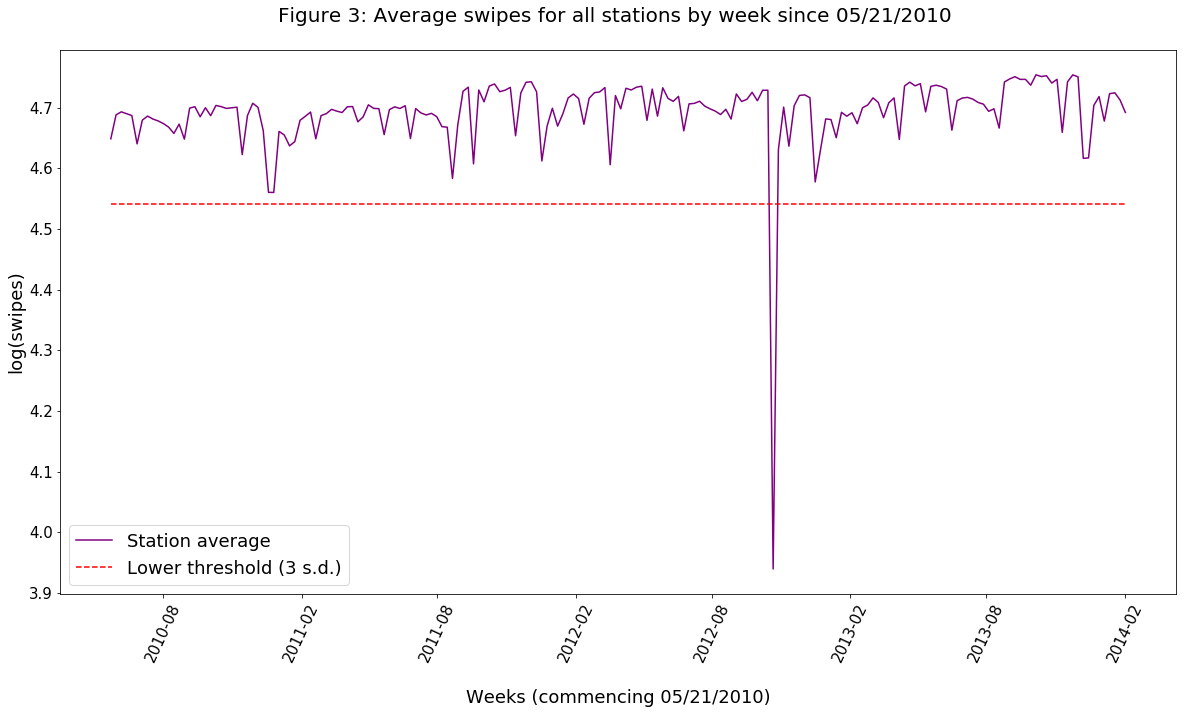

In [18]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)


ax.plot(dates, np.log10(avgStationSwipesCount), color='purple'
        , label = "Station average")
ax.plot(dates, thresh, 'r--', label = "Lower threshold (3 s.d.)")
    #ax.set_yscale('log')
ax.tick_params(axis='both',labelsize=16)
pl.title("Figure 3: Average swipes for all stations by week since 05/21/2010 \n", fontsize=20)
pl.xticks(rotation='65', fontsize = 15)
pl.yticks(fontsize = 15)
#ax.xaxis.set_major_formatter(FuncFormatter(format_fn))
#ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_ylabel("log(swipes)", fontsize=18)
ax.set_xlabel("\nWeeks (commencing 05/21/2010)", fontsize=18)
ax.set_ylim()#5,6)#0,100)1e4,1e6);
ax.set_xlim()
plt.legend(fontsize=18);

**Figure 3:** Plot of average swipes across all stations by week over time.

Again, the significant drop appears to be consistent across the average swipes by station also.

In [19]:
WeekID = np.argmin(avgStationSwipesCount)
print("The week number of the specific event is {}".format(WeekID) + 
      " which corresponds to the week {}".format(dates[WeekID]))

The week number of the specific event is 126 which corresponds to the week 2012-10-21 00:00:00


The week numbers are consistent also across average of all stations and the busiest stations. A search of events occuring in New York in late October 2012 reveal, this timing coincides with the events of **hurricane Sandy**. The drop in swipes is as a result of hurricane Sandy.

## Task 2: 
### Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)


In [20]:
np.nansum(theDataClean,axis=0).shape

(23, 194)

In [21]:
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])

### Plot of swipes by ride type

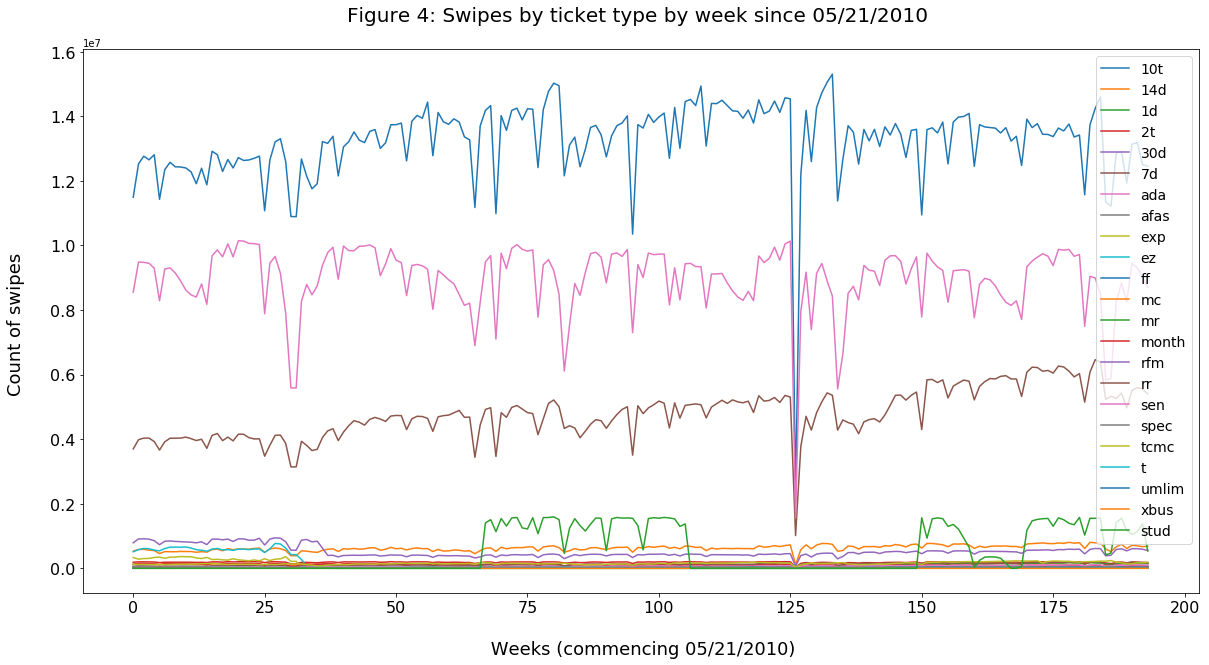

In [22]:

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)

for i in range(len(np.nansum(theDataClean,axis=0))):
    plot(np.nansum(theDataClean,axis=0)[i], label = ridetype[i] )
    
ax.tick_params(axis='both',labelsize=16)
pl.title("Figure 4: Swipes by ticket type by week since 05/21/2010 \n", fontsize=20)
ax.set_ylabel("Count of swipes \n", fontsize=18)
ax.set_xlabel("\n Weeks (commencing 05/21/2010)", fontsize=18)
ax.set_ylim()#3,60,100)1e4,1e6);
ax.set_xlim()#0,100)
plt.legend(fontsize=14);
    

We want to test if ridership is stationary across each of the ticket types. We will use the Augmented Dickey–Fuller test for unit root to test if the riderships are stationary.

**Stating the Null Hypothesis:** Testing ridership over time, the null hypothesis is that the the ridership has a unit root and is non-stationary

$H_0$: The series has a unit root and is non-stationary

$H_a$: The series has no unit root. The series is stationary

$\alpha=0.05$

In [23]:
sigLevel = 0.05 #alpha

In [24]:
#set-up empty array to populate with ridership ratios
RidershipDifferences = arange(len(np.nansum(theDataClean,axis=0))) * 0 
RidershipDifferences = RidershipDifferences.astype(np.float16)

#set-up empty array to pValue results for stationarity
pValueResult = arange(len(np.nansum(theDataClean,axis=0))) * 0 
pValueResult = RidershipDifferences.astype(np.float16)

# Calculate TOTAL rider for first 10 weeks and last 10 weeks
firstTenWeeksRidershipTotal = np.nansum(np.nansum(theDataClean,axis=0)[:,0:10])
lastTenWeeksRidershipTotal = np.nansum(np.nansum(theDataClean,axis=0)[:,-10:])

# Set up pandas dataframe to store percentage differences by ticket type, and p-value of statistical test
columns=['TicketType', 'RidershipPercentChange', 'pValueResult']
dfResults = pd.DataFrame(columns=columns)

for i in range(len(np.nansum(theDataClean,axis=0))):
    
    firstTenWeeksRidershipTicketRatio = np.nansum(np.nansum(theDataClean,axis=0)[i][0:10]) / firstTenWeeksRidershipTotal
    lastTenWeeksRidershipTicketRatio = np.nansum(np.nansum(theDataClean,axis=0)[i][-10:]) / lastTenWeeksRidershipTotal
    #print(firstTenWeeksRidershipTicketRatio, lastTenWeeksRidershipTicketRatio)

    ridershipDiff = format(lastTenWeeksRidershipTicketRatio - firstTenWeeksRidershipTicketRatio)
    RidershipDifferences[i] = ridershipDiff
    
    pVal = sm.tsa.adfuller(np.nansum(theDataClean,axis=0)[i])[1]  # Idenitifies p-value for AD-Fuller test
    pValueResult[i] = pVal

    dfResults.loc[i]= [ridetype[i] , ridershipDiff, pVal]

In [25]:
dfNonStatResults = dfResults[dfResults['pValueResult'] > sigLevel]
dfNonStatResults 

,TicketType,RidershipPercentChange,pValueResult
1,14d,0.00375146346251,0.222908
2,1d,0.00011514176431,0.232794
5,7d,0.0458635531056,0.525873
7,afas,-0.000384442153745,0.086881
9,ez,-0.0209821133335,0.118460
10,ff,-0.000310123097749,0.536185
11,mc,0.000756997384033,0.872198
12,mr,0.00482757408485,0.931244
13,month,-0.00213908669686,0.548666
14,rfm,-0.011140694143,0.231693


In [26]:
for i in dfNonStatResults.index:
    print("Ridership of {}".format(dfNonStatResults['TicketType'][i]) + " is non-stationary. Observed change" + 
          " in ridership % b/w the first 10 and last 10 weeks is {}%"
          .format(round(float(dfNonStatResults['RidershipPercentChange'][i]),4)*100))

Ridership of 14d is non-stationary. Observed change in ridership % b/w the first 10 and last 10 weeks is 0.38%
Ridership of 1d is non-stationary. Observed change in ridership % b/w the first 10 and last 10 weeks is 0.01%
Ridership of 7d is non-stationary. Observed change in ridership % b/w the first 10 and last 10 weeks is 4.59%
Ridership of afas is non-stationary. Observed change in ridership % b/w the first 10 and last 10 weeks is -0.04%
Ridership of ez is non-stationary. Observed change in ridership % b/w the first 10 and last 10 weeks is -2.1%
Ridership of ff is non-stationary. Observed change in ridership % b/w the first 10 and last 10 weeks is -0.03%
Ridership of mc is non-stationary. Observed change in ridership % b/w the first 10 and last 10 weeks is 0.08%
Ridership of mr is non-stationary. Observed change in ridership % b/w the first 10 and last 10 weeks is 0.48%
Ridership of month is non-stationary. Observed change in ridership % b/w the first 10 and last 10 weeks is -0.21%
R

Overall there are 15 ticket types identified as non-stationary. This means there are observed trends in their complete series. 

However, when comparing the ridership % of the first 10 weeks with the last 10 weeks, sometimes very small percentage difference is observed (such as 1d, afas, ff, mc, and xbus ticket types). 

They must have trends throughout the year, but when comparing the two 10 week time periods there isn't a large observed difference.


## Task 3:
### Several stations show a prominent annual periodicity. Identify the 4 **stations** (identify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)

In [27]:
# We're interested in the individual stations (600 of them),
# We collapse the fare type dimension (axis number 1)
mtaSwipesAllStations = np.nansum(theDataClean, axis=1)

In [28]:
mtaSwipesAllStations_power = range(len(mtaSwipesAllStations))

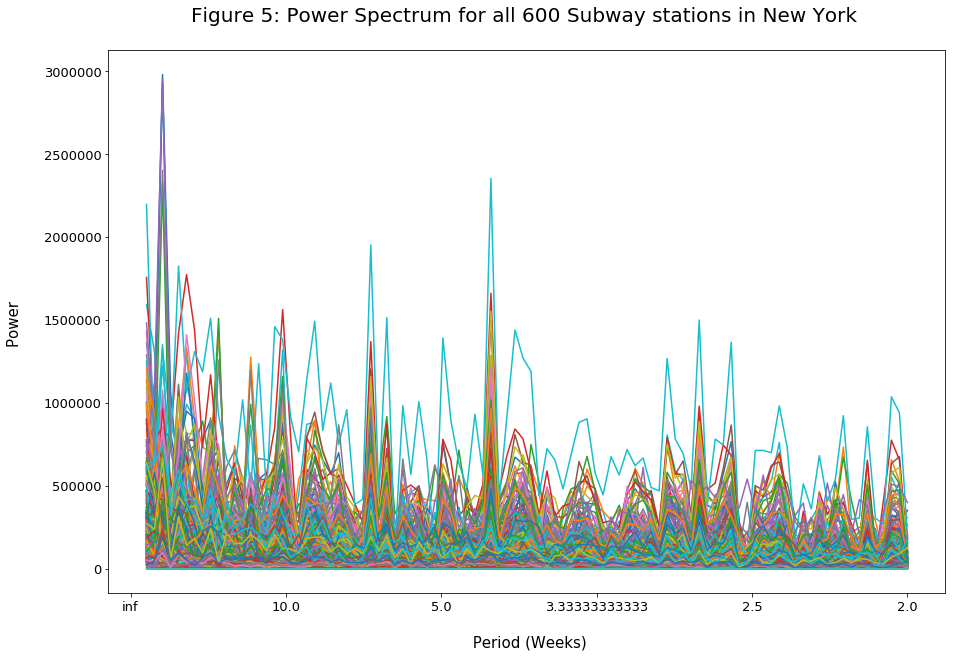

In [29]:

# Visually inspect all the stations plotting their power spectrum, excluding the first two elements on the X
# (Frequencies that correspond Infinity and the whole period: "Uninteresting")
# as explained in https://github.com/fedhere/UInotebooks/blob/master/timeseries/fourier.ipynb

N = len(mtaSwipesAllStations[1])
fig=pl.figure(figsize=(15,10))
ax=fig.add_subplot(111)


# Create a dictionary to store the frequency bin centers in cycles per week (X Axis)
# and the Fourier Transform value (Y) for eac of the stations

mtaSwipesAllStations_yearPeriodicity = {}

for i in range (len(mtaSwipesAllStations)):
    f = np.abs(np.fft.rfft(mtaSwipesAllStations[i]))
    ffreq = np.fft.rfftfreq(N, 1.0)
    mtaSwipesAllStations_power[i]=(ffreq,f)
    ax.plot(ffreq[2:], (f[2:]), '-')
    mtaSwipesAllStations_yearPeriodicity[i]=((f[4]))

ax.set_xticklabels([ "%s"%(1/f) for f in ax.get_xticks()], fontsize=20)
pl.xlabel("\n Period (Weeks)", fontsize=15)
pl.ylabel("Power \n", fontsize=15)
ax.tick_params(axis='both',labelsize=13)

ax.set_title('Figure 5: Power Spectrum for all 600 Subway stations in New York \n', fontsize=20);

**Figure 5:** Plot of the power spectrum of the 600 stations. 

Whilst there are a lot of series plotted on this chart, and it's difficult to gain a precise picture, we are able to observe the large spikes at certain frequencies.

This gives us some idea about which periodicity at certain frequencies which we'll explore further.



In [30]:
# Explore the frequency bins

print ("Center of the bin 3: " + str(1 / ffreq [3]) + ' Weeks')
print ("Center of the bin 4: " + str(1 / ffreq [4]) + ' Weeks')
print ("Center of the bin 5: " + str(1 / ffreq [5]) + ' Weeks')

Center of the bin 3: 64.6666666667 Weeks
Center of the bin 4: 48.5 Weeks
Center of the bin 5: 38.8 Weeks


In [31]:
# The fourth position of the array (1 / 48.5 weeks) is the closest (year is aprox 52.1429 weks)
# Lets get the stations with the higher values for this bin
# Will use collections.counter, code snippet from
# http://stackoverflow.com/questions/11902665/top-values-from-dictionary

d = collections.Counter(mtaSwipesAllStations_yearPeriodicity)
most_yearly_periodic_stations = []

for k, v in d.most_common(4):
    most_yearly_periodic_stations.append(k)

print ("The most common stations with yearly period are: " + str (most_yearly_periodic_stations))

The most common stations with yearly period are: [0, 194, 150, 327]


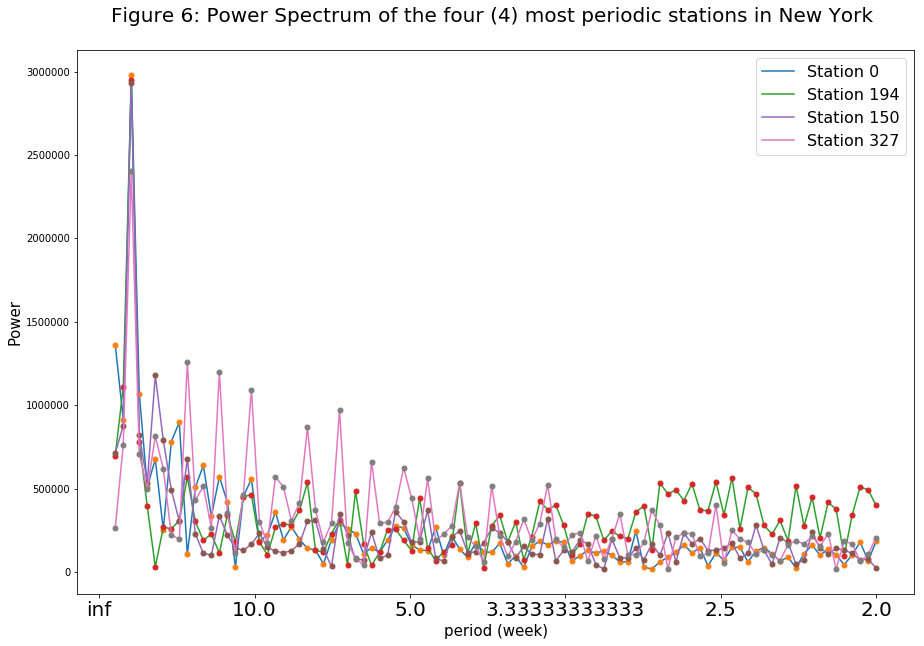

In [32]:
# Visualize the power spectrum only for those four stations (cleaner chart!)

N = len(mtaSwipesAllStations[1])
fig=pl.figure(figsize=(15,10))
ax=fig.add_subplot(111)
pl.xlabel("period (week)", fontsize=15)
pl.ylabel("Power", fontsize=15)


for i in range(len(most_yearly_periodic_stations)):
    f = np.abs(np.fft.rfft(mtaSwipesAllStations[most_yearly_periodic_stations[i]]))
    ffreq = np.fft.rfftfreq(N, 1.0)
    mtaSwipesAllStations_power[i]=(ffreq,f)
    ax.plot(ffreq[2:], (f[2:]), '-', label="Station " + str(most_yearly_periodic_stations[i]))
    ax.plot(ffreq[2:], (f[2:]), 'o', ms=5)
    mtaSwipesAllStations_yearPeriodicity[i]=((f[4]))

ax.legend(loc='best', fontsize=16)
ax.set_xticklabels([ "%s"%(1/f) for f in ax.get_xticks()], fontsize=20);

ax.set_title('Figure 6: Power Spectrum of the four (4) most periodic stations in New York \n', fontsize=20);


**Figure 6:** This plot presents the power spectrum of the four (4) most periodic stations in New York.

Now we have identified the most yearly periodic stations, we will attempt to understand reasons for this periodicity. As we dont have any data that relates the station to a particular location, we will just look into the dates where these surges happen. For this we will plot only these stations swipes

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


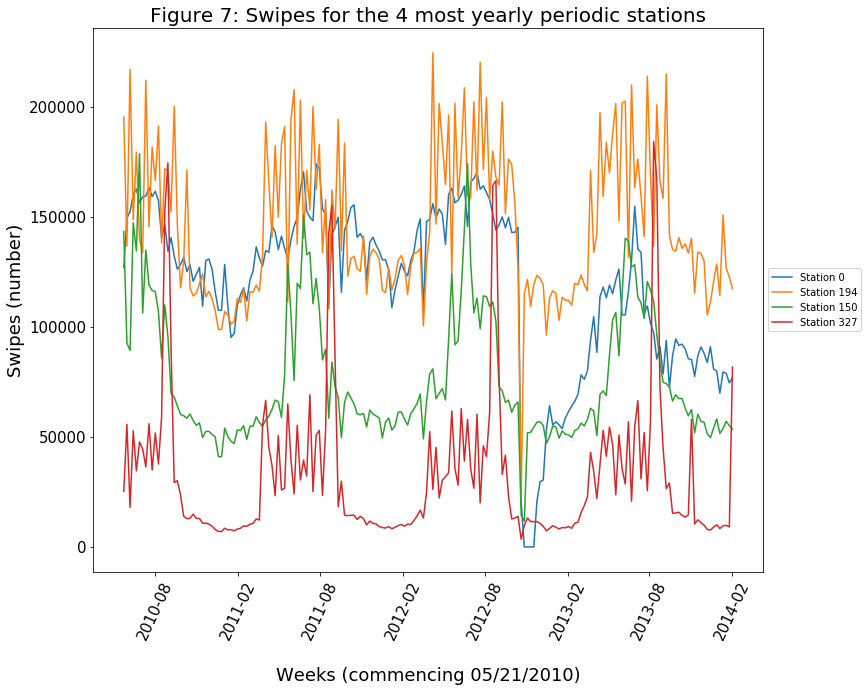

In [33]:
# Plotting the station swipes and dates to try to find possible events that explain the periodicity

fig=pl.figure(figsize=(15,10))
ax=fig.add_subplot(111)
pl.xlabel("\nWeeks (commencing 05/21/2010)", fontsize=18)
pl.ylabel("Swipes (number)", fontsize=18)
ax.legend(loc='best', fontsize=16)
pl.title("Figure 7: Swipes for the 4 most yearly periodic stations", fontsize=20)
pl.xticks(rotation='65', fontsize = 15)
pl.yticks(fontsize = 15)

for i in range(len(most_yearly_periodic_stations)):
    ax.plot(dates, mtaSwipesAllStations[most_yearly_periodic_stations[i]], 
            '-', label="Station " + str(most_yearly_periodic_stations[i]))
    
# Shrink current axis by 20%
# So I can put a legend to the right of the current axis
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));


**Figure 7:** This plot presents the swipes per week for the top 4 most periodic stations in New York.

From the new visualization we can see that the stations 327, 194 and 150 display the most clear annual periodicity with quite regular periods of spikes between April and September (warmer months). This might be related to the fact that these stations are used to access open spaces that are mostly used with warm weather. Station 0 seems to also present periodicity related to the warmer months, but it appears to be less pronounced.

Station 327 has a very clear spike somewhere around September, this might relate to a concrete event. Will take a period of a single year and visualize these three stations with better visibility on the X axis

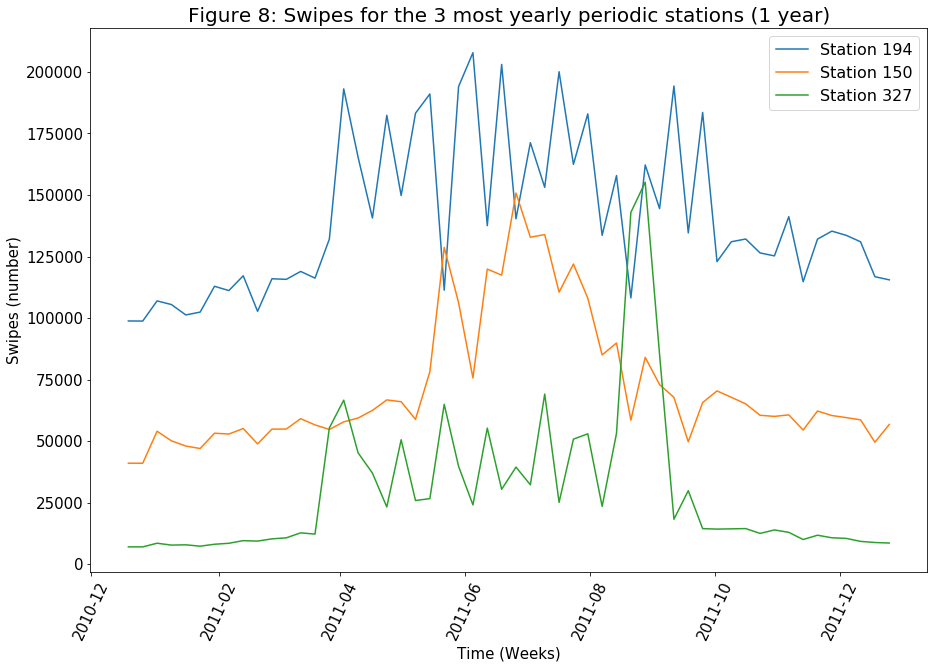

In [34]:
# Plotting the station swipes and dates to try to find possible events that explain the preiodicity

fig=pl.figure(figsize=(15,10))
ax=fig.add_subplot(111)
pl.xlabel("Time (Weeks)", fontsize=15)
pl.ylabel("Swipes (number)", fontsize=15)
ax.legend(loc='best', fontsize=12)
pl.title("Figure 8: Swipes for the 3 most yearly periodic stations (1 year)", fontsize=20)
pl.xticks(rotation='65', fontsize = 15)
pl.yticks(fontsize = 15)

# Remember the array with the top 5 periodic
# [0, 194, 150, 327, 32]

ax.plot(dates[30:84], mtaSwipesAllStations[most_yearly_periodic_stations[1]][30:84], 
            '-', label="Station " + str(most_yearly_periodic_stations[1]))
ax.plot(dates[30:84], mtaSwipesAllStations[most_yearly_periodic_stations[2]][30:84], 
            '-', label="Station " + str(most_yearly_periodic_stations[2]))
ax.plot(dates[30:84], mtaSwipesAllStations[most_yearly_periodic_stations[3]][30:84], 
            '-', label="Station " + str(most_yearly_periodic_stations[3]))
ax.legend(fontsize=16, loc='best');

**Figure 8:** This plot presents the swipes per week for the top 3 most periodic stations in Manhattan for a period of 52 weeks

## THANK YOU.